In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
plt.style.use('ggplot')

%matplotlib inline

In [4]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [5]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [6]:
input_len = 16 # try wider window power of 2
horizon = 7 # prediction window

In [7]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


In [8]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


In [9]:
import math

import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset

from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

seismic_start = seismic.epoch.values[0]
seismic_end = seismic.epoch.values[-1]
    
pressure_start = pressure.epoch.values[0]
pressure_end = pressure.epoch.values[-1]
t0 = max(seismic_start, pressure_start)
t1 = min(seismic_end, pressure_end)

Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

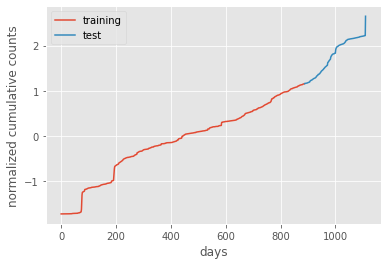

In [10]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    train_test_split=0.8, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

In [11]:
len(train_dset.X) 

888

### Model Architecture

In [12]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [13]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

# Choose your loss function!
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

### Trial 1

In [14]:

from tqdm.notebook import tqdm

In [15]:
torch.manual_seed(0) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))
test_loss_vals_1 = test_loss_vals
train_loss_vals_1 = train_loss_vals

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

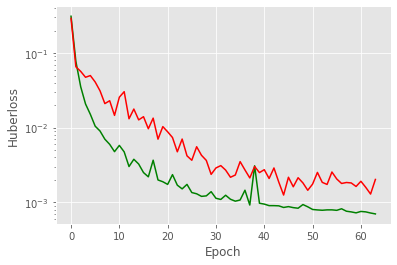

In [16]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')



In [17]:
# print Huber Loss
test_loss_vals_1 = test_loss_vals
test_loss_vals_1

[0.29098896256514956,
 0.06553025809781891,
 0.05677916282521827,
 0.04737821673708303,
 0.04993432347795793,
 0.0409367718467755,
 0.031214894128165076,
 0.021056217972987464,
 0.022981771766873344,
 0.014639159248742675,
 0.025636213598772883,
 0.03038941416889429,
 0.013192262633570604,
 0.01779236373425062,
 0.012745222309604287,
 0.014056129489160542,
 0.009699023598971377,
 0.013446540721426052,
 0.0070370555747233865,
 0.010355894166942952,
 0.008819117830301235,
 0.007400038743591202,
 0.0047656773198728585,
 0.00705814389844558,
 0.00421005511972388,
 0.003672173770610243,
 0.005570014152908698,
 0.0042805841824572,
 0.003656650217765543,
 0.0023775200742030783,
 0.0028990584645985757,
 0.003113653398551313,
 0.0027119752776343375,
 0.0021743754561092438,
 0.002331003742126216,
 0.003519616212413114,
 0.002723751400480978,
 0.002130534894864208,
 0.003031771596787231,
 0.002509659844300976,
 0.002746211414757584,
 0.002093419908695588,
 0.0028954180182024303,
 0.00187414573572

### Trial 2

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

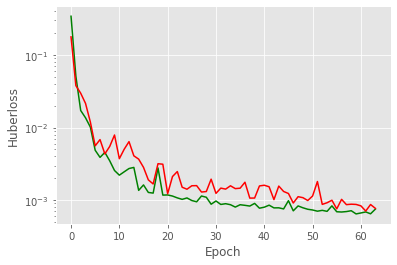

In [18]:
torch.manual_seed(1) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


n_epoch = 64
for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_2 = test_loss_vals
train_loss_vals_2 = train_loss_vals

plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')

### Trial 3

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

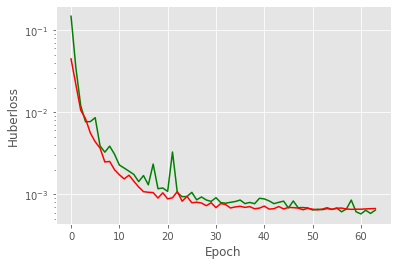

In [19]:
torch.manual_seed(3) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_3 = test_loss_vals
train_loss_vals_3 = train_loss_vals

plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


### Trial 4

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

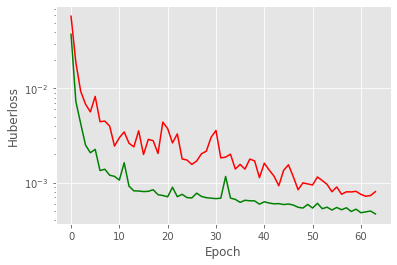

In [20]:
torch.manual_seed(4) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_4 = test_loss_vals
train_loss_vals_4 = train_loss_vals


plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


### Trial 5

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

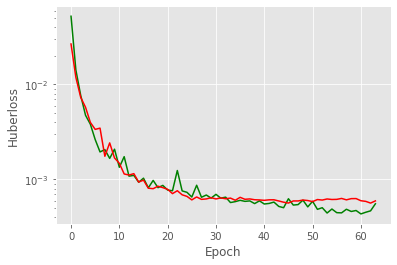

In [21]:
torch.manual_seed(5) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_5 = test_loss_vals
train_loss_vals_5 = train_loss_vals


plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


### Trial 6

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

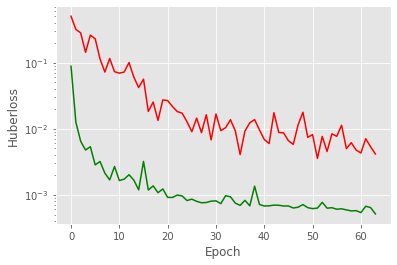

In [22]:
torch.manual_seed(6) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_6 = test_loss_vals
train_loss_vals_6 = train_loss_vals


plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


### Trial 7

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

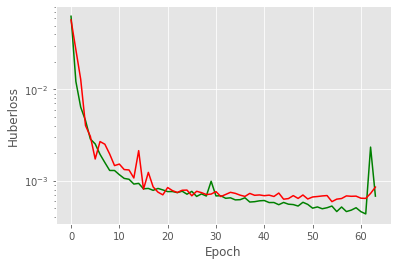

In [23]:
torch.manual_seed(7) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_7 = test_loss_vals
train_loss_vals_7 = train_loss_vals


plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


### Trial 8

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

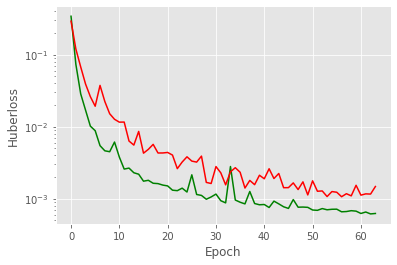

In [24]:
torch.manual_seed(8) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_8 = test_loss_vals
train_loss_vals_8 = train_loss_vals


plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


### Trial 9

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

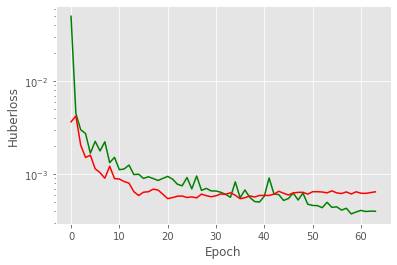

In [25]:
torch.manual_seed(9) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_9 = test_loss_vals
train_loss_vals_9 = train_loss_vals


plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


### Trial 10

  0%|          | 0/64 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

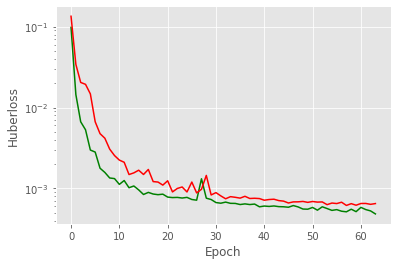

In [26]:
torch.manual_seed(10) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)


train_loss_vals = []
test_loss_vals = []

n_epoch = 64

for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

test_loss_vals_10 = test_loss_vals
train_loss_vals_10 = train_loss_vals


plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')


Visualize the forecast

## Calculate mean Huber Loss and STD

In [27]:
final_test_loss = np.array([test_loss_vals_1[-1],test_loss_vals_2[-1],
                test_loss_vals_3[-1],test_loss_vals_4[-1],
                test_loss_vals_5[-1],test_loss_vals_6[-1],
                test_loss_vals_7[-1],test_loss_vals_8[-1],
                test_loss_vals_9[-1],test_loss_vals_10[-1]])

final_test_loss

In [28]:
# print average
np.mean(final_test_loss)

0.00126157937858287

In [29]:
# print std
np.std(final_test_loss)

0.0010503389036738545

In [30]:
train_loss = np.array([train_loss_vals_1,train_loss_vals_2,
                train_loss_vals_3,train_loss_vals_4,
                train_loss_vals_5,train_loss_vals_6,
                train_loss_vals_7,train_loss_vals_8,
                train_loss_vals_9,train_loss_vals_10])

In [31]:
test_losses = np.array([test_loss_vals_1,test_loss_vals_2,
                test_loss_vals_3,test_loss_vals_4,
                test_loss_vals_5,test_loss_vals_6,
                test_loss_vals_7,test_loss_vals_8,
                test_loss_vals_9,test_loss_vals_10])

In [32]:
pd.DataFrame(test_losses).transpose().to_csv('test_losses.csv')

In [41]:
loss_trial_5 = pd.DataFrame({'epoch':np.arange(64),
                        'train_loss':train_loss_vals_5,
                        'test_loss':test_loss_vals_5})
loss_trial_5.to_csv('huber_loss.csv',index=None)

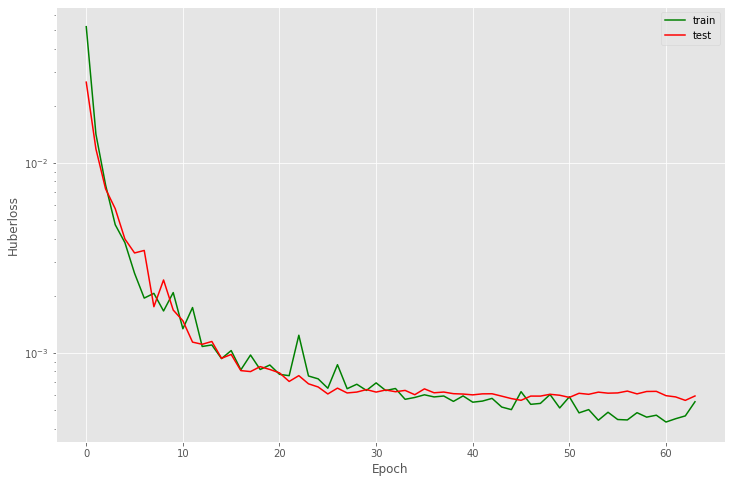

In [46]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(train_loss_vals_5, color='g', label='train')
plt.plot(test_loss_vals_5, color='r', label='test')
plt.ylabel('Huberloss')
plt.legend()
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')
plt.savefig('huber_loss.png')